# Predicting the delays of flights

*Work in Progress*

The goal is to predict the expected delay of a flight based on variables assumed to be known by the traveller like the time of the departure, the destination, the name of the airline...

**Objectives:**
- Fitting a Ridge regression model
- Building a composite pipeline to handle different pre-processing steps depending on the nature (numerical or categorical) of the features
- Setting a cross-validation procedure to find the optimal hyper-parameters

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dataset

The dataset *flight.csv* describes airline on-time performances for the year 2016 in the USA and can be found in the /data subfolder. 

I don't reproduce here the cleaning and formating process. In summary:

1. Original data can be found on the [Bureau of Transportation Statistics website](https://www.transtats.bts.gov/)
2. I downloaded the data *Airline On-Time Performance* for the whole yaer 2016 ending with approximately 5.10^6 lines
3. I dropped lines with cancelled flights and kept only a few features (see flight.csv)
4. Variables CRS_DEP and CRS_ARR, coded in 'hhmm' format were converted into minutes and renamed 'dep_min' and arr_min', respectively
- Finally, I sampled randomly 10% of the dataset to obtain a smaller dataset for the purpose of this work (~5 10^5 lines)

Note: airlines are coded in the dataset, the actual names for each code can be found on the BTS site (and can be downloaded) 

## 1. Exploration

In [2]:
sample_final = pd.read_csv('data/flight.csv',index_col=0)
print(sample_final.shape)
display(sample_final.head())
print(sample_final.columns)

(551140, 11)


,ARR_DELAY,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,CRS_ELAPSED_TIME,DISTANCE,dep_min,arr_min
1242654,4.0,3,20,7,AA,BWI,DFW,222.0,1217.0,1090,1252
1460502,-17.0,4,25,1,WN,MDW,ATL,110.0,591.0,575,745
2719565,56.0,6,20,1,AA,DFW,LAS,170.0,1055.0,890,940
94381,115.0,1,13,3,B6,PBI,LGA,160.0,1035.0,1159,1319
238994,46.0,1,10,7,DL,ATL,MSP,172.0,907.0,985,1097


Index(['ARR_DELAY', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER',
       'ORIGIN', 'DEST', 'CRS_ELAPSED_TIME', 'DISTANCE', 'dep_min', 'arr_min'],
      dtype='object')


### target to predict: delay at arrival

defining outliers as points outside 3 IQR (inter quartile range).
(we could use 3  or 4 SD but we should assume a gaussian distribution first)

In [3]:
q25, q75 = np.percentile(sample_final['ARR_DELAY'], 25), np.percentile(sample_final['ARR_DELAY'], 75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 3.0
lower, upper = q25 - cut_off, q75 + cut_off
print('cut-off values (3.0 iqr):', lower, upper)
## works only for elemnt-wise operator '&'; 'and' would raise an error
inliers = sample_final[(sample_final['ARR_DELAY']>lower) & \
             (sample_final['ARR_DELAY']<upper)]
print('{}% of data are in the range [{}, {}] minutes'.format(
    round(inliers.shape[0]/sample_final.shape[0],4)*100,
    lower, upper))

cut-off values (3.0 iqr): -74.0 66.0
95.09% of data are in the range [-74.0, 66.0] minutes


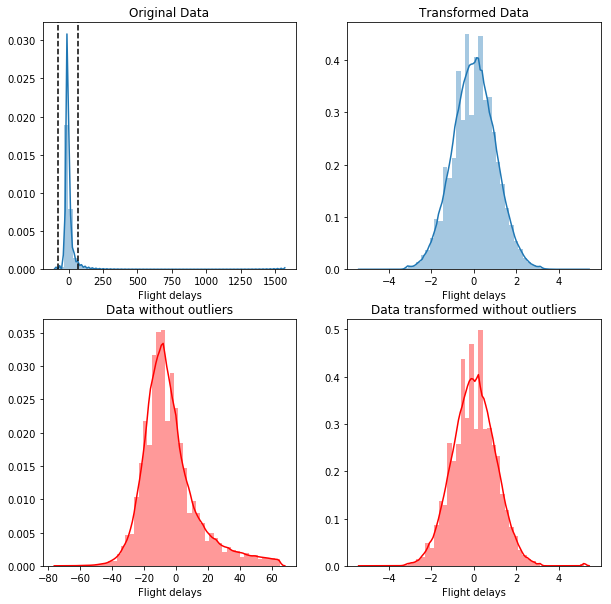

In [4]:
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

target = sample_final['ARR_DELAY']
target_inlier = inliers['ARR_DELAY']
target_qt =  QuantileTransformer(n_quantiles=1000, 
            output_distribution='normal').fit_transform(
            target.values.reshape(-1, 1))
target_inlier_qt =  QuantileTransformer(n_quantiles=1000, 
            output_distribution='normal').fit_transform(
            target_inlier.values.reshape(-1, 1))
# Plot Original Data
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.distplot(target, bins=50)
plt.plot([lower, lower], [0,1], c='black', ls='--')
plt.plot([upper, upper], [0,1], c='black', ls='--')
plt.title('Original Data')
plt.xlabel('Flight delays')

plt.subplot(2,2,2)
sns.distplot(target_qt, bins=50)
#plt.plot([lower, lower], [0,1], c='black', ls='--')
#plt.plot([upper, upper], [0,1], c='black', ls='--')
plt.title('Transformed Data')
plt.xlabel('Flight delays')

# Plot Data without outliers
plt.subplot(2,2,3)
sns.distplot(target_inlier, bins=50, color='r')
plt.title('Data without outliers')
plt.xlabel('Flight delays')

plt.subplot(2,2,4)
sns.distplot(target_inlier_qt, bins=50, color='r')
plt.title('Data transformed without outliers')
plt.xlabel('Flight delays')
plt.show()

Most of the delay lies in the [-20, 20] minutes range but outliers can go up to 1500 minutes. When we discard the outliers the distrinution is still skewed to the right. A quantile transformation allows to obtain a more gaussian shape

### Numerical variables: Flight distances and expected flight duration

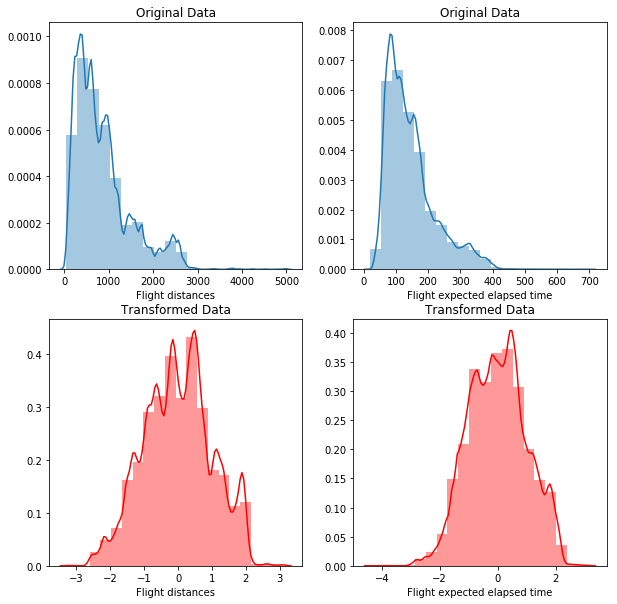

In [5]:
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

target_dist = sample_final['DISTANCE']
target_elapsed = sample_final['CRS_ELAPSED_TIME']
dist_pt =  PowerTransformer().fit_transform(
            target_dist.values.reshape(-1, 1))
elapsed_pt =  PowerTransformer().fit_transform(
            target_elapsed.values.reshape(-1, 1))

# Plot Original Data
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.distplot(target_dist, bins=20)
plt.title('Original Data')
plt.xlabel('Flight distances')

plt.subplot(2,2,2)
sns.distplot(target_elapsed, bins=20)
plt.title('Original Data')
plt.xlabel('Flight expected elapsed time')

# Plot Data without outliers
plt.subplot(2,2,3)
sns.distplot(dist_pt, bins=20, color='r')
plt.title('Transformed Data')
plt.xlabel('Flight distances')

plt.subplot(2,2,4)
sns.distplot(elapsed_pt, bins=20, color='r')
plt.title('Transformed Data')
plt.xlabel('Flight expected elapsed time')
plt.show()

Distributions of *Flight distances* and *Flight expected elapesed time* are skewed to the right. Power transformation can be used to get a more symmetric shape.

### Categorical variables: Airlines and Airports

In [6]:
## downloaded on site BTS
carrier_decode = pd.read_csv('data/CARRIER_DECODE.csv')
carrier_decode.head()

,AIRLINE_ID,CARRIER,CARRIER_ENTITY,CARRIER_NAME,UNIQUE_CARRIER,UNIQUE_CARRIER_ENTITY,UNIQUE_CARRIER_NAME,WAC,CARRIER_GROUP,CARRIER_GROUP_NEW,REGION,START_DATE_SOURCE,THRU_DATE_SOURCE,Unnamed: 13
0,19031,MAC,30550,Mackey International Inc.,MAC,30550,Mackey International Inc.,10,1,6,Domestic,1960-01-01,1982-12-31,NaN
1,19032,XY,04530,Munz Northern Airlines Inc.,XY,04530,Munz Northern Airlines Inc.,10,1,1,Domestic,1960-01-01,1983-09-30,NaN
2,19033,COC,30337,Cochise Airlines Inc.,COC,30337,Cochise Airlines Inc.,10,1,6,Domestic,1960-01-01,1984-12-31,NaN
3,19034,GSA,37760,Golden Gate Airlines Inc.,GSA,37760,Golden Gate Airlines Inc.,10,1,6,Domestic,1960-01-01,1984-12-31,NaN
4,19035,RZZ,30012,Aeromech Inc.,RZZ,30012,Aeromech Inc.,10,1,6,Domestic,1960-01-01,1984-12-31,NaN


In [7]:
airline = {}
for code in pd.unique(sample_final['UNIQUE_CARRIER']):
    airline[code] = carrier_decode[carrier_decode['UNIQUE_CARRIER']==code]['UNIQUE_CARRIER_NAME'].iloc[0]
airline

{'AA': 'American Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'B6': 'JetBlue Airways',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'ExpressJet Airlines Inc.',
 'F9': 'Frontier Airlines Inc.',
 'HA': 'Hawaiian Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'OO': 'SkyWest Airlines Inc.',
 'UA': 'United Air Lines Inc.',
 'VX': 'Virgin America',
 'WN': 'Southwest Airlines Co.'}

airline: dictionary with the correspondances between codes and airlines complete names

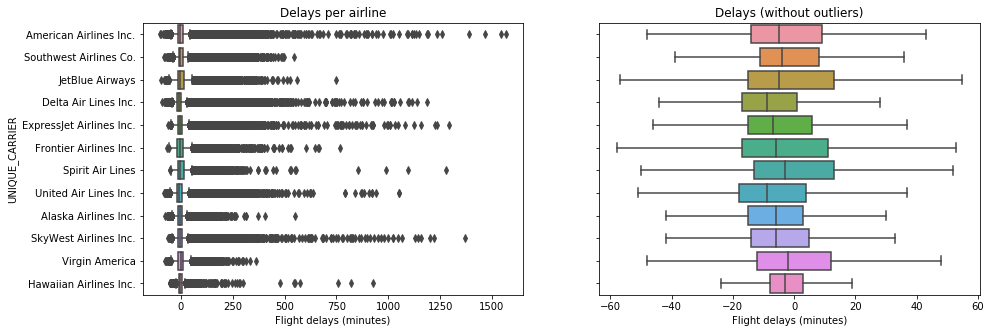

In [8]:
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
ax=sns.boxplot(y='UNIQUE_CARRIER',x='ARR_DELAY', data=sample_final, orient="h", showfliers =True)
texts = [t.get_text()  for t in ax.get_yticklabels()]
labels = [airline[x] for x in texts]
ax.set_yticklabels(labels)
plt.xlabel('Flight delays (minutes)')
plt.title('Delays per airline')

plt.subplot(1,2,2)
ax=sns.boxplot(y='UNIQUE_CARRIER',x='ARR_DELAY', data=sample_final, orient="h", showfliers =False)
ax.set_yticklabels('')
plt.ylabel('')
plt.xlabel('Flight delays (minutes)')
plt.title('Delays (without outliers)')
plt.show()

In [9]:
print('Number of Origin Airports in the dataset: ', sample_final['ORIGIN'].nunique())

Number of Origin Airports in the dataset:  308


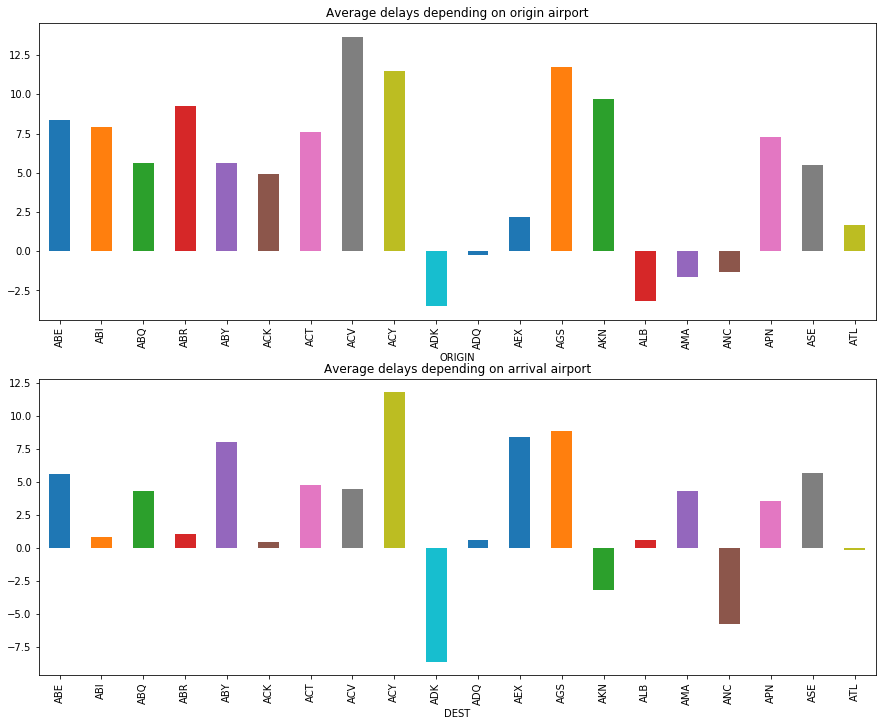

In [10]:
# Let's show only 20 airports...
plt.figure(figsize=(15, 12))
plt.subplot(2,1,1)
tmp_org = sample_final.groupby('ORIGIN')['ARR_DELAY'].mean()
tmp_org[:20].plot(kind='bar')
plt.title("Average delays depending on origin airport")
plt.subplot(2,1,2)
tmp_dest = sample_final.groupby('DEST')['ARR_DELAY'].mean()
tmp_dest[:20].plot(kind='bar')
plt.title("Average delays depending on arrival airport")
plt.show()

### Temporal variables: date of the flight

In [11]:
import datetime
import math

def min_to_hh(val):
    val = val/60
    val = math.floor(val)
    return(val)

def min_to_min(val):
    val = val%60
    return(val)

hh = sample_final.loc[:,'dep_min'].apply(min_to_hh)
mm = sample_final.loc[:,'dep_min'].apply(min_to_min)

date_vol = sample_final.loc[:,['MONTH', 'DAY_OF_MONTH']]
date_vol['YEAR'] = 2016
date_vol = date_vol[['YEAR','MONTH', 'DAY_OF_MONTH']]
date_vol.columns = ['YEAR', 'MONTH', 'DAY']
date_vol['hour'] = hh
date_vol['minute'] = mm

date_vol = pd.to_datetime(date_vol)
date_vol.head()

1242654   2016-03-20 18:10:00
1460502   2016-04-25 09:35:00
2719565   2016-06-20 14:50:00
94381     2016-01-13 19:19:00
238994    2016-01-10 16:25:00
dtype: datetime64[ns]

To look at the temporal trend, it's more convenient to build a feature in datetime format

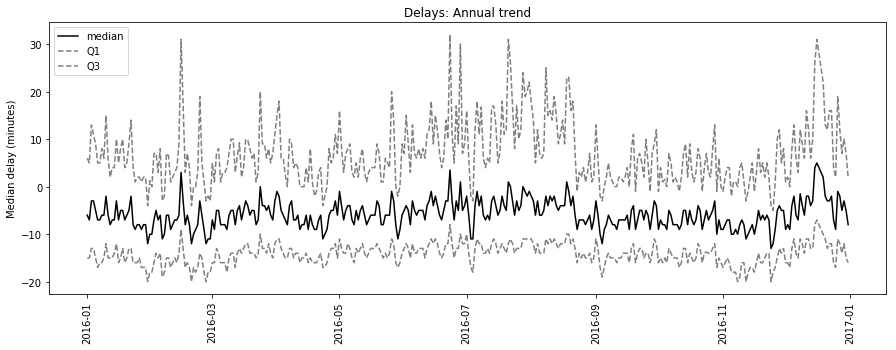

In [13]:
# Daily medians of delays
tmp_day= date_vol.apply(lambda x: x.date())
tmp = sample_final.groupby(tmp_day)['ARR_DELAY'].quantile(0.5)
tmp25 = sample_final.groupby(tmp_day)['ARR_DELAY'].quantile(0.25)
tmp75 = sample_final.groupby(tmp_day)['ARR_DELAY'].quantile(0.75)

plt.figure(figsize=(15, 5))
plt.plot(tmp,color='black',ls='-')
plt.plot(tmp25,color='grey',marker='',ls='--')
plt.plot(tmp75,color='grey',marker='',ls='--')
plt.title('Delays: Annual trend')
plt.ylabel('Median delay (minutes)')
plt.xticks(rotation=90)
plt.legend(['median','Q1','Q3'])


plt.show()

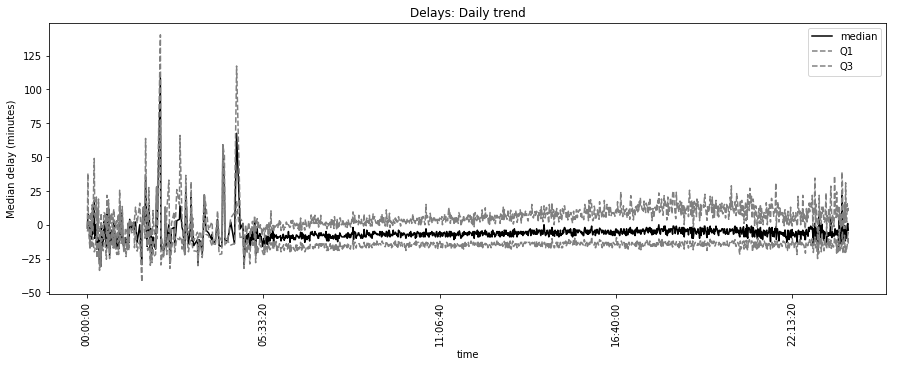

In [14]:
tmp_time= date_vol.apply(lambda x: x.time())
tmp = sample_final.groupby(tmp_time)['ARR_DELAY'].quantile(0.5)
tmp25 = sample_final.groupby(tmp_time)['ARR_DELAY'].quantile(0.25)
tmp75 = sample_final.groupby(tmp_time)['ARR_DELAY'].quantile(0.75)

plt.figure(figsize=(15, 5))
plt.plot(tmp,color='black',ls='-')
plt.plot(tmp25,color='grey',marker='',ls='--')
plt.plot(tmp75,color='grey',marker='',ls='--')
plt.title('Delays: Daily trend')
plt.ylabel('Median delay (minutes)')
plt.xticks(rotation=90)
plt.legend(['median','Q1','Q3'])


plt.show()

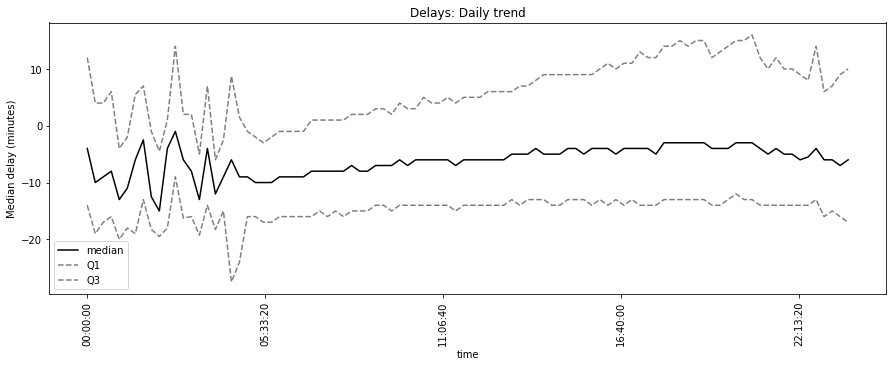

In [15]:
## departure times aggregated by 15 minutes

def round_time(tmp_time,arr=10):
    tmp = datetime.time(tmp_time.hour, tmp_time.minute//arr*arr)
    return tmp

tmp_time= date_vol.apply(lambda x: x.time())
tmp_arr = tmp_time.apply(round_time,arr=15)
tmp = sample_final.groupby(tmp_arr)['ARR_DELAY'].quantile(0.5)
tmp25 = sample_final.groupby(tmp_arr)['ARR_DELAY'].quantile(0.25)
tmp75 = sample_final.groupby(tmp_arr)['ARR_DELAY'].quantile(0.75)

plt.figure(figsize=(15, 5))
plt.plot(tmp,color='black',ls='-')
plt.plot(tmp25,color='grey',marker='',ls='--')
plt.plot(tmp75,color='grey',marker='',ls='--')
plt.title('Delays: Daily trend')
plt.ylabel('Median delay (minutes)')
plt.xticks(rotation=90)
plt.legend(['median','Q1','Q3'])


plt.show()

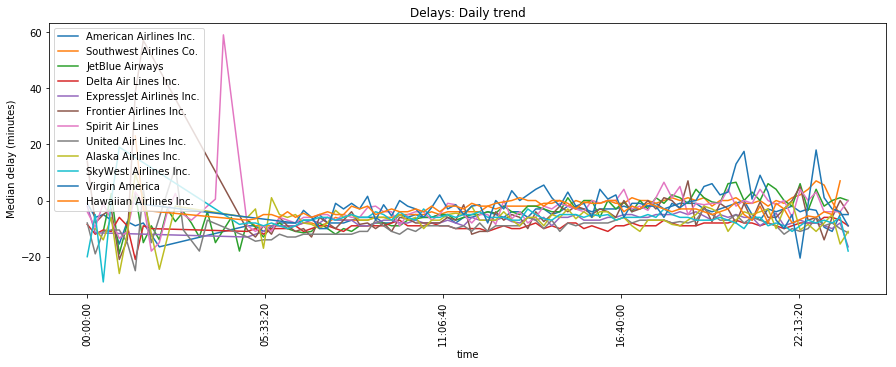

In [16]:
palette = sns.color_palette(None, 12)
plt.figure(figsize=(15, 5))
i=0
for carrier in airline.keys():    
    tmp = sample_final[sample_final.UNIQUE_CARRIER==carrier].groupby(tmp_arr)['ARR_DELAY'].quantile(0.5)
    plt.plot(tmp,color=palette[i],label=airline[carrier])
    i+=1
plt.title('Delays: Daily trend')
plt.ylabel('Median delay (minutes)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## 2. Biplots

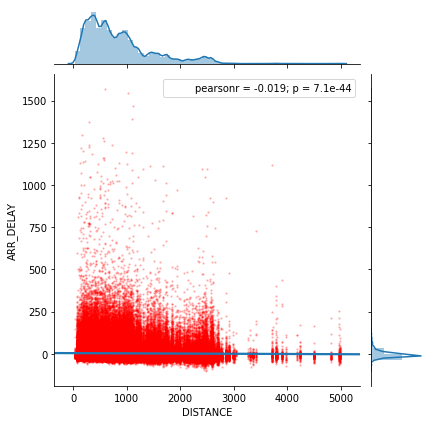

In [17]:
sns.jointplot(x='DISTANCE', y='ARR_DELAY', data=sample_final, kind="reg",
              scatter_kws={'s':2, 'color':'red', 'alpha': 0.2}, n_boot=50);

seaborn joinplot is a nice way to show the relation between 2 variables together with the distributions of both variables.

However with so many data points it's hard to figure how the density of points vary.

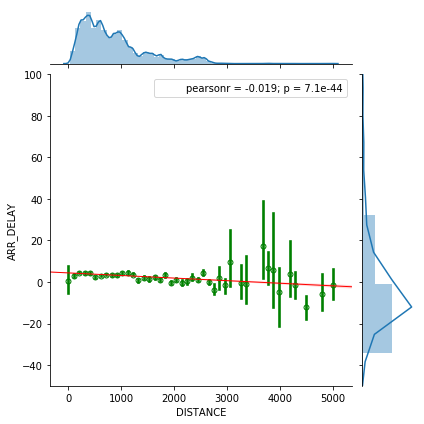

In [18]:
sns.jointplot(x='DISTANCE', y='ARR_DELAY', data=sample_final, kind="reg",
              x_bins=np.linspace(0,5000), line_kws={'lw':1, 'color':'red'},
              scatter=True, scatter_kws={'lw':5,'s':1, 'color':'green', 'alpha': 1},
             ylim=(-50,100),
             n_boot=50, ## for faster computation default value =1000
             );

An option of joinplot function allows to plot the mean values of y=ARR_DELAY for different bins of the X variable. The vertical bars displayed on the graph correspond to the IC of each mean measurements. The regression is still calculated on the intial data

Finally, to represent the density of the points I'd rather like to show the boxplots with the quanties values of the Y variable for each bins of the X variable

In [19]:
def custom_plot(data=sample_final, x_var='DISTANCE', y_var='ARR_DELAY',
               ylim=(-50,200),n_boot=50, min_bin=0, max_bin=5000, num=50):
    
    end=num-1
    binned = pd.cut(data[x_var],bins=np.linspace(min_bin,max_bin,num=num),
                    retbins=False,labels=list(np.linspace(min_bin,max_bin,num=num)[:end]))
    liste = []
    for i in np.linspace(min_bin,max_bin,num=num)[:end]:
        liste.append(list(data[binned==i][y_var]))
    
    from sklearn.linear_model import LinearRegression
    X = data[x_var].values.reshape(-1, 1)  
    Y = data[y_var].values.reshape(-1, 1)  
    linear_regressor = LinearRegression()  
    linear_regressor.fit(X, Y)  
    Y_pred = linear_regressor.predict(X)  
    
    gra=sns.jointplot(x=x_var, y=y_var, data=data, kind="reg",
              line_kws={'lw':1, 'color':'red'},
              joint_kws={'scatter':False}, 
              ylim=ylim,
              n_boot=n_boot, ## for faster computation default value =1000
             );
    gra.ax_joint.boxplot(liste,showfliers=False,
                         positions=np.linspace(min_bin,max_bin,num=num)[:end],
           meanline=False, showmeans=True,
           meanprops=dict(marker='D', markeredgecolor='black',markerfacecolor='black',
                          linewidth=5,alpha=0.5),
           boxprops={'color':'green', 'linewidth':5}, whis=[5,95])
    gra.ax_joint.plot(X, Y_pred, color='red') #redraw the regression line to see it better
    gra.ax_joint.set_xticks(np.arange(min_bin,max_bin+1,step=max_bin//5))
    gra.ax_joint.set_xticklabels(np.arange(min_bin,max_bin+1,step=max_bin//5))
    plt.show()

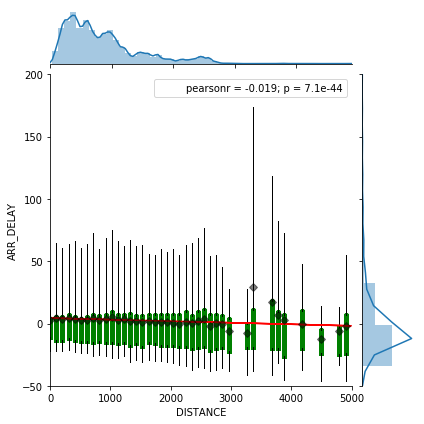

In [20]:
custom_plot(data=sample_final, x_var='DISTANCE', y_var='ARR_DELAY', ylim=(-50,200),
            n_boot=50, min_bin=0, max_bin=5000, num=50)

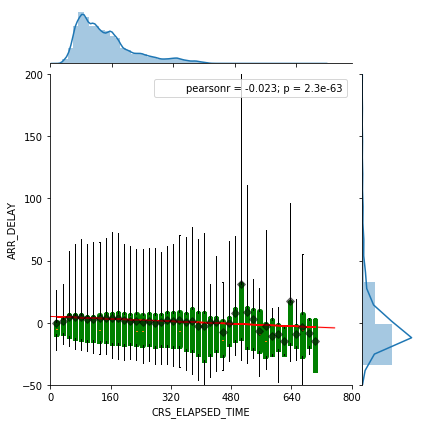

In [21]:
custom_plot(data=sample_final, x_var='CRS_ELAPSED_TIME', y_var='ARR_DELAY', ylim=(-50,200),
            n_boot=50, min_bin=0, max_bin=800, num=50)

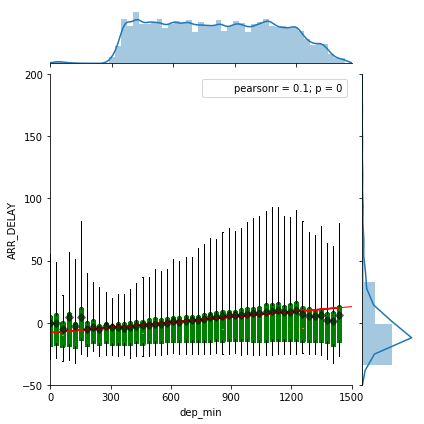

In [22]:
custom_plot(data=sample_final, x_var='dep_min', y_var='ARR_DELAY', ylim=(-50,200),
            n_boot=50, min_bin=0, max_bin=1500, num=50)

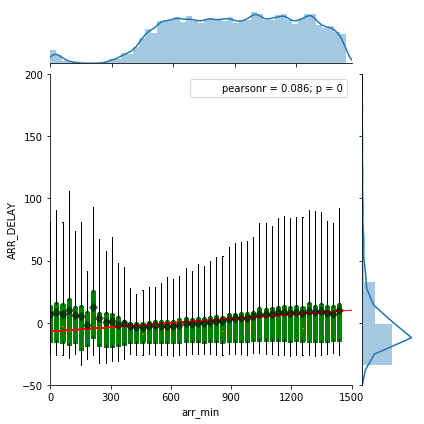

In [23]:
custom_plot(data=sample_final, x_var='arr_min', y_var='ARR_DELAY', ylim=(-50,200),
            n_boot=50, min_bin=0, max_bin=1500, num=50)

## 3. Model

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import timeit

### Pipeline

In [26]:
target = sample_final['ARR_DELAY']
numeric_features = ['CRS_ELAPSED_TIME', 'DISTANCE', 'dep_min', 'arr_min']
categorical_features = ['UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']

######## Preprocessor: combined data types
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))#,
    #('svd', TruncatedSVD(random_state=0)) # if we want to speed up model computation
])
numeric_transformer = Pipeline(steps=[
    ('powert', PowerTransformer()),
    ('polynomial', PolynomialFeatures()), 
    ('scaler', StandardScaler())
                                     ]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
        ])

########### Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(regressor=linear_model.Ridge()))
     ])

####### Parameter Grid
param_grid = {
    #'preprocessor__cat__svd__n_components': [100],
    'preprocessor__num__polynomial__degree': [3], 
    'regressor__regressor__alpha': [100],
    'regressor__transformer': [None] #, QuantileTransformer(output_distribution='normal')]
}

In [27]:
start_time = timeit.default_timer()

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs = -1, verbose = 2)
grid_search.fit(sample_final, target)

print('Model\'s Best Parameters: ',grid_search.best_params_)
y_true, y_pred = target, grid_search.predict(sample_final) 
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: ',rmse)

end_time = timeit.default_timer()
print('elapsed: ', end_time-start_time)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.8s finished


Model's Best Parameters:  {'preprocessor__num__polynomial__degree': 3, 'regressor__regressor__alpha': 100, 'regressor__transformer': None}
RMSE:  40.52429911566
elapsed:  69.59532969368765


In [28]:
target = sample_final['ARR_DELAY']
numeric_features = ['CRS_ELAPSED_TIME', 'DISTANCE', 'dep_min', 'arr_min']
categorical_features = ['UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'MONTH',
                        'DAY_OF_MONTH', 'DAY_OF_WEEK']

######## Preprocessor: combined data types
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))#,
    #('svd', TruncatedSVD(random_state=0)) # if we want to speed up model computation
])
numeric_transformer = Pipeline(steps=[
    ('powert', PowerTransformer()),
    ('polynomial', PolynomialFeatures()), 
    ('scaler', StandardScaler())
                                     ]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
        ])

########### Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(regressor=linear_model.Ridge()))
     ])

####### Parameter Grid
param_grid = {
    #'preprocessor__cat__svd__n_components': [100],
    'preprocessor__num__polynomial__degree': [1, 2, 3, 4], 
    'regressor__regressor__alpha': [0.1, 1, 10, 100, 250],
    'regressor__transformer': [None, QuantileTransformer(output_distribution='normal')] #]
}

In [29]:
start_time = timeit.default_timer()

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs = -1, verbose = 2)
grid_search.fit(sample_final, target)

print('Model\'s Best Parameters: ',grid_search.best_params_)
y_true, y_pred = target, grid_search.predict(sample_final) 
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: ',rmse)

end_time = timeit.default_timer()
print('elapsed: ', end_time-start_time)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 33.3min finished


Model's Best Parameters:  {'preprocessor__num__polynomial__degree': 4, 'regressor__regressor__alpha': 100, 'regressor__transformer': None}
RMSE:  40.51602324274377
elapsed:  2130.8162513676602


### with train/test split...

In [30]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(sample_final.drop(columns=['ARR_DELAY']),
                    sample_final['ARR_DELAY'], test_size = 0.25, random_state = 0)

In [34]:
####### Parameter Grid
param_grid = {
    'preprocessor__num__polynomial__degree': [4], 
    'regressor__regressor__alpha': [100],
    'regressor__transformer': [None] 
}

start_time = timeit.default_timer()

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print('Model\'s Best Parameters: ',grid_search.best_params_)
y_true, y_pred = y_test, grid_search.predict(X_test) 
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: ',rmse)

end_time = timeit.default_timer()
print('elapsed: ', end_time-start_time)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Model's Best Parameters:  {'preprocessor__num__polynomial__degree': 4, 'regressor__regressor__alpha': 100, 'regressor__transformer': None}
RMSE:  41.461666436455225
elapsed:  173.42143410811786
